In [1]:
import os
os.chdir('..')
news_path = 'data/cleaned_text/states_full.csv'
preprocessed_pickle_path = 'big-data/preprocessed.pkl'
w2v_model_path = 'big-data/w2v_model.pkl'

# Packages and Presets

In [109]:
# auxiliary
import numpy as np
import pandas as pd
import copy
import time
import pickle

# Analytics
import gensim
from sklearn.decomposition import NMF # Faster topic modeling
from sklearn.decomposition import TruncatedSVD # SVD for sparse matrices
import nltk
stopwords = nltk.corpus.stopwords.words('english')

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Custom package
import nlp.preprocessing as prep

pd.set_option('display.max_rows', 8)

# Data Prep

In [15]:
news = pd.read_csv(news_path, encoding = "ISO-8859-1")
news['new_text'] = news['new_text'].fillna('').astype(str)

In [18]:
# function to perform lemmatize and stem preprocessing steps on the data set.
t = time.time()
preprocessor = prep.Preprocessor(news['new_text'])
preprocessor.preprocess(lemmatize=True, # stopwords=, 
                        min_token_length=3)
print(time.time() - t)

157.35520434379578


In [19]:
t = time.time()
preprocessor.get_bigrams_from_preprocessed()
print(time.time() - t)

34.80204439163208


In [20]:
t = time.time()
preprocessor.create_nlp_items_from_preprocessed_df(no_below=2, verbose=True)

dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
                                                             preprocessor.bow_corpus_,
                                                             preprocessor.tfidf_,
                                                             preprocessor.corpus_tfidf_,
                                                             preprocessor.tfidf_sparse_)
print(time.time() - t)

0 accord
1 act
2 add
3 addit
4 advertis
5 american_evacu
6 american_evacue
7 antonio
8 antonio_express
9 antonio_texa
10 appropri

 122439 unique words. 

49951 unique words after extremes filtered. 


Word 32 ("confirm_case") appears 1 time.
Word 34 ("coronavirus") appears 3 time.
Word 47 ("famili") appears 1 time.
Word 50 ("friday") appears 1 time.
Word 54 ("home") appears 2 time.
Word 60 ("inmat") appears 2 time.
Word 65 ("like") appears 1 time.
Word 81 ("peopl") appears 1 time.
Word 89 ("quarantin") appears 1 time.
Word 94 ("relat") appears 1 time.
Word 101 ("say") appears 3 time.
Word 108 ("spread") appears 1 time.
Word 109 ("state") appears 2 time.
Word 111 ("symptom") appears 1 time.
Word 119 ("week") appears 2 time.
Word 122 ("work") appears 1 time.
Word 127 ("area") appears 1 time.
Word 148 ("incarcer") appears 2 time.
Word 149 ("includ") appears 1 time.
Word 166 ("prison") appears 7 time.
Word 177 ("staff") appears 1 time.
Word 179 ("step") appears 1 time.
Word 184 ("test_pos

In [24]:
# f = open(preprocessed_pickle_path, "wb") # remember to open the file in binary mode
# pickle.dump(preprocessor, f)
# f.close()

# preprocessor = pickle.load(preprocessed_pickle_path)

# dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
#                                                              preprocessor.bow_corpus_,
#                                                              preprocessor.tfidf_,
#                                                              preprocessor.corpus_tfidf_,
#                                                              preprocessor.tfidf_sparse_)

# Topic Modeling

In [141]:
terms = list(dictionary.token2id.keys())

In [162]:
# Ensure coherence between dict and preprocessed text
preprocessed_text = []
for e, doc in enumerate(preprocessor.preprocessed_text_):
    doc_refined = []
    for word in doc:
        if word in terms:
            doc_refined.append(word)
    preprocessed_text.append(doc_refined)
    
    if e % 100 == 0:
        print(e)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900


In [173]:
t = time.time()
w2v_model = gensim.models.Word2Vec(preprocessed_text, size=500, min_count=preprocessor.dictionary_no_below_, sg=1)
print(time.time() - t)

192.922532081604


In [174]:
# f = open(w2v_model_path, "wb") # remember to open the file in binary mode
# pickle.dump(w2v_model, f)
# f.close()

In [175]:
topic_models = []
for n_topics in range(2, 10):
    t = time.time()
    nmf = NMF(n_components=n_topics, random_state=20)
    nmf_transformed = nmf.fit_transform(tfidf_sparse)
    topic_models.append([n_topics, nmf_transformed, nmf.components_])
    print('n topics: ' + str(n_topics))
    print(time.time() - t)

n topics: 2
1.7469167709350586
n topics: 3
1.8218727111816406
n topics: 4
2.208632230758667
n topics: 5
4.309331655502319
n topics: 6
3.6977081298828125
n topics: 7
4.207395315170288
n topics: 8
5.731450319290161
n topics: 9
11.908628702163696


In [176]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [177]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [191]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top n terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 300 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Users\vldoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


K=02: Coherence=0.2259
K=03: Coherence=0.2530
K=04: Coherence=0.2756
K=05: Coherence=0.2795
K=06: Coherence=0.2819
K=07: Coherence=0.2794
K=08: Coherence=0.2875
K=09: Coherence=0.2939


LDA would be too slow with 8-9k documents and 50k words. Using NMF instead.

In [179]:
nmf = NMF(n_components=4, random_state=20)
nmf_transformed = nmf.fit_transform(tfidf_sparse)

In [180]:
def print_top_words_nmf(nmf_model, dictionary, n_top_words=10):
    for topic_idx, topic in enumerate(nmf_model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([dictionary[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()
        
print_top_words_nmf(nmf, dictionary, n_top_words=10)

Topic #0: prison jail inmat peopl say releas state counti correct depart

Topic #1: detaine immigr detent_center detent immigr_custom immigr_detent bergen_counti cook_counti jail enforc

Topic #2: ohio dewin marion_correct depart_rehabilit marion test prison mass case report

Topic #3: william hillsborough_counti chronist second_degre sheriff drug_paraphernalia possess_heroin florida sheriff_chad emerg_commit



In [184]:
topics_assigned = np.argmax(nmf_transformed, axis=1)

In [185]:
truncatedsvd = TruncatedSVD(n_components = 30, algorithm = 'randomized', random_state = 20)
svd_transformed = truncatedsvd.fit_transform(tfidf_sparse)

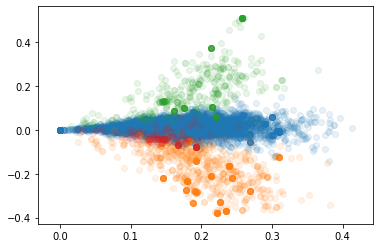

In [186]:
for i in range(n_topics):
    indices = np.argwhere(topics_assigned == i)
    plt.scatter(svd_transformed[indices,0], svd_transformed[indices,1], alpha = 0.1)

https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

## Subtopic Analytics

In [195]:
indices_bigtopic = np.argwhere(topics_assigned == 0).T[0]
preprocessed_text_bigtopic = [txt for e, txt in enumerate(preprocessed_text) if e in indices_bigtopic]

In [196]:
w2v_model_bigtopic = gensim.models.Word2Vec(
    preprocessed_text_bigtopic,
    size=500, min_count=preprocessor.dictionary_no_below_, sg=1)

In [200]:
topic_models = []
for n_topics in range(2, 10):
    t = time.time()
    nmf = NMF(n_components=n_topics, random_state=20)
    nmf_transformed = nmf.fit_transform(tfidf_sparse[indices_bigtopic])
    topic_models.append([n_topics, nmf_transformed, nmf.components_])
    print('n topics: ' + str(n_topics))
    print(time.time() - t)

n topics: 2
1.4890775680541992
n topics: 3
1.507068157196045
n topics: 4
2.107693672180176
n topics: 5
5.338694095611572
n topics: 6
9.08037781715393
n topics: 7
8.47375202178955
n topics: 8
8.213910102844238
n topics: 9
13.103886365890503


In [205]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top n terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 100 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model_bigtopic, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Users\vldoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


K=02: Coherence=0.3063
K=03: Coherence=0.3267
K=04: Coherence=0.3214
K=05: Coherence=0.3034
K=06: Coherence=0.3060
K=07: Coherence=0.3239
K=08: Coherence=0.3383
K=09: Coherence=0.3280


In [211]:
nmf = NMF(n_components=3, random_state=20)
nmf_transformed = nmf.fit_transform(tfidf_sparse[indices_bigtopic])
topics_assigned = np.argmax(nmf_transformed, axis=1)
print_top_words_nmf(nmf, dictionary, n_top_words=20)

Topic #0: prison inmat jail peopl say state releas correct feder counti test incarcer depart facil staff offici offic popul court work

Topic #1: virginia resid juvenil_justic children sever_cold outsid_richmond virginia_louisiana juvenil_detent advoc test_posit washington boykin famili_valeri higher_josh heart_actual frustrat_littl boykin_facil expect_relax counsel_frequent brother_avula

Topic #2: solano_counti nurs sheriffâ_offic deputi jail prepar_statement court_proceed natur serv counti confirm sheriff_ferrara commission_bryan direct_note afternoon_arraign long_qualifi nick_filloy establish_intak review_concur note_ferrara



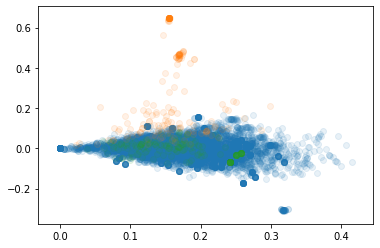

In [212]:
truncatedsvd = TruncatedSVD(n_components = 30, algorithm = 'randomized', random_state = 20)
svd_transformed = truncatedsvd.fit_transform(tfidf_sparse[indices_bigtopic])

for i in range(n_topics):
    indices = np.argwhere(topics_assigned == i)
    plt.scatter(svd_transformed[indices,0], svd_transformed[indices,1], alpha = 0.1)